In [1]:
import pandas as pd
import math
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import time
import sys
from pixell import enmap, enplot, reproject, utils, curvedsky, wcsutils
from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from tqdm import tqdm

In [87]:
amf = pd.read_csv('../../data/dr9_main_complete.csv', header=None)
amf.columns = ['amf_no','amf_ra','amf_dec','amf_z','amf_lk','amf_rh','amf_r200','amf_rc','amf_c','amf_str_rh','bax_id','mcxc_id','red_id','whl_id']

c = SkyCoord(amf['amf_ra'],amf['amf_dec'],frame='icrs',unit='deg')
amf['glat'] = c.galactic.b.degree
amf['glon'] = c.galactic.l.degree
amf['cat'] = 0
amf_whl = amf[(amf.whl_id!='-9999')]

In [88]:
hdul = fits.open("../../data/galaxy_clusters_desdr2.fits")
data = hdul[1].data
zou1 = pd.DataFrame({'ra':data['RA_PEAK'],
                    'dec':data['DEC_PEAK'],
                    'z':data['PHOTO_Z_PEAK'],
                    'rh':data['RICHNESS']})
c = SkyCoord(zou1['ra'],zou1['dec'],frame='icrs',unit='deg')
zou1['glat'] = c.galactic.b.degree
zou1['glon'] = c.galactic.l.degree
zou1['cat'] = 1

In [89]:
hdul = fits.open("../../data/galaxy_clusters_desidr9.fits")
data = hdul[1].data
zou2 = pd.DataFrame({'ra':data['RA_PEAK'],
                    'dec':data['DEC_PEAK'],
                    'z':data['PHOTO_Z_PEAK'],
                    'rh':data['RICHNESS']})
c = SkyCoord(zou2['ra'],zou2['dec'],frame='icrs',unit='deg')
zou2['glat'] = c.galactic.b.degree
zou2['glon'] = c.galactic.l.degree
zou2['cat'] = 2

In [116]:
zou3

,ra,dec,z,rh,glat,glon,cat
0,214.233624,52.908531,1.171777,97.716247,59.717726,97.090269,3
1,214.244321,53.084990,0.935550,236.463383,59.578309,97.304716,3
2,214.095757,52.893964,1.307441,248.589667,59.782274,97.198288,3
3,214.132952,52.864502,1.269002,276.290641,59.790493,97.126519,3
4,213.401525,52.763087,0.095811,33.717130,60.149420,97.680603,3
...,...,...,...,...,...,...,...
36561,37.121633,-7.040413,0.762745,93.215806,-59.446130,176.275838,3
36562,37.505307,-6.801662,1.233534,103.779296,-59.006203,176.456392,3
36563,37.351173,-6.656354,1.232472,63.698972,-59.015181,176.046844,3
36564,37.213823,-6.731959,0.764592,119.749692,-59.165654,175.966990,3


In [90]:
hdul = fits.open("../../data/galaxy_clusters_hscpdr3_wide.fits")
data = hdul[1].data
zou3 = pd.DataFrame({'ra':data['RA_PEAK'],
                    'dec':data['DEC_PEAK'],
                    'z':data['PHOTO_Z_PEAK'],
                    'rh':data['RICHNESS']})
c = SkyCoord(zou3['ra'],zou3['dec'],frame='icrs',unit='deg')
zou3['glat'] = c.galactic.b.degree
zou3['glon'] = c.galactic.l.degree
zou3['cat'] = 3

In [91]:
zou = pd.concat([zou1,zou2,zou3])

In [92]:
# Mass in 10^14
wh22 = pd.read_csv('../../data/cluster_DESunWISE.dat', sep='\s+', header=None, usecols=[3,4,5,10,11])
wh22.columns = ['ra','dec','z','rh','m']
c = SkyCoord(wh22['ra'],wh22['dec'],frame='icrs',unit='deg')
wh22['glat'] = c.galactic.b.degree
wh22['glon'] = c.galactic.l.degree
wh22['cat'] = 4

In [93]:
# wh22.to_csv('wh22.csv')
# wh22 = pd.read_csv('../../data/wh22.csv')

In [94]:
# dcl.z = np.array(dcl.z).byteswap().newbyteorder()

show counts for each

(array([3.8498e+04, 3.6476e+04, 9.5210e+03, 1.8530e+03, 4.5100e+02,
        1.1000e+02, 3.2000e+01, 1.6000e+01, 4.0000e+00, 2.0000e+00]),
 array([6.45937209e-03, 8.25858252e+01, 1.65165191e+02, 2.47744557e+02,
        3.30323923e+02, 4.12903289e+02, 4.95482654e+02, 5.78062020e+02,
        6.60641386e+02, 7.43220752e+02, 8.25800118e+02]),
 <BarContainer object of 10 artists>)

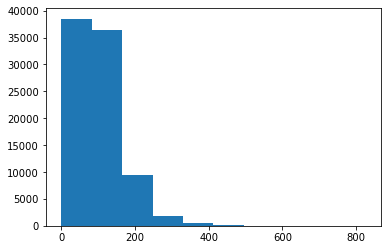

In [154]:
plt.hist(zou1.rh)

(array([ 2935., 12104., 13680., 18314., 13313., 10577.,  5286.,  3978.,
         6430.,   346.]),
 array([0.02984642, 0.16462612, 0.29940584, 0.43418553, 0.56896526,
        0.70374495, 0.83852464, 0.97330433, 1.1080841 , 1.2428638 ,
        1.3776435 ], dtype=float32),
 <BarContainer object of 10 artists>)

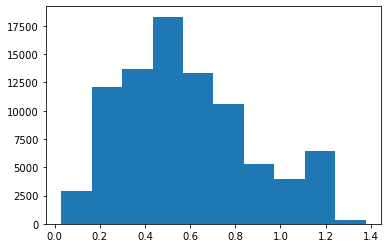

In [153]:
plt.hist(zou1.z)

In [146]:
zou0[(zou0.cat==2) & (zou0.z>0.6)& (zou0.z<1)]

,amf_ra,amf_dec,z,rh,cat
0,135.576658,84.282097,0.672224,71.125599,2
4,159.441977,84.470371,0.774722,131.296879,2
6,169.336282,84.745055,0.739466,186.789902,2
7,170.173343,84.497271,0.739765,123.796251,2
14,209.629132,84.575575,0.714163,61.195763,2
...,...,...,...,...,...
532787,65.460255,-66.866127,0.772272,90.605660,2
532788,65.332630,-66.820162,0.742248,75.869274,2
532789,66.479394,-67.250996,0.704453,94.599666,2
532790,67.524140,-66.458386,0.674120,69.780400,2


In [95]:
amf0 = amf.rename(columns={'amf_ra':'amf_ra','amf_dec':'amf_dec','amf_z':'z','amf_rh':'rh'})[['amf_ra','amf_dec','z','rh','cat']]
zou0 = zou.rename(columns={'ra':'amf_ra','dec':'amf_dec'})[['amf_ra','amf_dec','z','rh','cat']]
wh220 = wh22.rename(columns={'ra':'amf_ra','dec':'amf_dec'})[['amf_ra','amf_dec','z','rh','cat']]

union = pd.concat([amf0,zou0,wh220])#.to_csv('../../data/union.csv')

In [96]:
# df = union.sort_values(['amf_ra','amf_dec'])
# df = df.sort_values(['amf_ra', 'amf_dec'])
# diff_a = df['amf_ra'].diff().abs()
# diff_b = df['amf_dec'].diff().abs()
# mask = (diff_a < 1e-4) & (diff_b < 1e-4)
# mask[0] = True
# df_filtered = df[mask]
# df_filtered.reset_index(drop=True, inplace=True)
# # df_filtered.to_csv('../../data/union2.csv')

In [121]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree

# Assuming you already have a DataFrame named 'df' with columns 'x' and 'y'
df = union.copy()
coords = df[['amf_ra', 'amf_dec','z']].values

# Create a k-d tree from the coordinates
tree = KDTree(coords)

# Query the k-d tree for nearest neighbors within 0.5 distance
# Note that each point will find itself as the nearest neighbor with distance 0
distances, indices = tree.query(coords, k=2, distance_upper_bound=1e-2)

# Check if there's any point within 0.5 distance for each row, excluding the point itself (hence k=2)
# We can do this by checking if the second smallest distance is <= 0.5
df['Match'] = distances[:, 1] <= 1e-2

In [130]:
df[df['Match']].round(1).drop_duplicates(subset=['amf_ra','amf_dec','z'])

,amf_ra,amf_dec,z,rh,cat,Match
22,347.1,-2.2,0.3,149.3,0,True
44,326.5,20.5,0.3,133.4,0,True
58,341.4,28.1,0.4,128.8,0,True
62,192.4,49.9,0.3,126.5,0,True
63,16.2,0.1,0.3,126.5,0,True
...,...,...,...,...,...,...
150554,359.1,2.4,0.4,25.5,4,True
150617,359.2,2.5,0.4,16.9,4,True
150635,359.3,-42.2,0.9,44.9,4,True
150680,359.3,-0.5,1.0,44.8,4,True


In [125]:
deswh = union[(union.cat.isin([1,4]))]

import pandas as pd
import numpy as np
from scipy.spatial import KDTree

# Assuming you already have a DataFrame named 'deswh' with columns 'x' and 'y'
coords = deswh[['amf_ra', 'amf_dec','z']].values

# Create a k-d tree from the coordinates
tree = KDTree(coords)

# Query the k-d tree for nearest neighbors within 0.5 distance
# Note that each point will find itself as the nearest neighbor with distance 0
distances, indices = tree.query(coords, k=2, distance_upper_bound=1e-2)

# Check if there's any point within 0.5 distance for each row, excluding the point itself (hence k=2)
# We can do this by checking if the second smallest distance is <= 0.5
deswh['Match'] = distances[:, 1] <= 1e-2

/tmp/ipykernel_408944/2086346163.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deswh['Match'] = distances[:, 1] <= 1e-2


add counts to paper

ValueError: Big-endian buffer not supported on little-endian compiler

In [131]:
deswh[deswh['Match']].round(1).drop_duplicates(subset=['amf_ra','amf_dec','z'])

,amf_ra,amf_dec,z,rh,cat,Match
3,0.8,5.3,0.2,112.9,1,True
44,12.7,4.9,0.5,127.8,1,True
97,26.6,4.9,0.7,134.4,1,True
132,32.5,5.0,0.6,151.1,1,True
141,35.4,5.1,0.8,132.8,1,True
...,...,...,...,...,...,...
145143,350.4,0.6,0.8,24.9,4,True
148011,355.2,-39.8,0.7,48.4,4,True
148139,355.4,-43.3,0.2,16.0,4,True
150516,359.1,-1.5,0.6,18.8,4,True


In [127]:
hscwh = union[(union.cat.isin([3,4]))]

import pandas as pd
import numpy as np
from scipy.spatial import KDTree

# Assuming you already have a DataFrame named 'hscwh' with columns 'x' and 'y'
coords = hscwh[['amf_ra', 'amf_dec','z']].values

# Create a k-d tree from the coordinates
tree = KDTree(coords)

# Query the k-d tree for nearest neighbors within 0.5 distance
# Note that each point will find itself as the nearest neighbor with distance 0
distances, indices = tree.query(coords, k=2, distance_upper_bound=1e-2)

# Check if there's any point within 0.5 distance for each row, excluding the point itself (hence k=2)
# We can do this by checking if the second smallest distance is <= 0.5
hscwh['Match'] = distances[:, 1] <= 1e-2

/tmp/ipykernel_408944/2098961799.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hscwh['Match'] = distances[:, 1] <= 1e-2


In [133]:
hscwh[hscwh['Match']].round(1).drop_duplicates(subset=['amf_ra','amf_dec','z'])

,amf_ra,amf_dec,z,rh,cat,Match
9012,15.7,2.6,0.5,188.7,3,True
9051,21.2,2.5,0.2,96.1,3,True
9101,32.2,3.0,0.4,55.6,3,True
9108,34.0,2.8,0.1,38.4,3,True
9171,38.9,2.9,0.9,135.0,3,True
...,...,...,...,...,...,...
58000,38.9,-1.9,0.7,49.0,4,True
136799,336.3,-0.4,0.8,41.1,4,True
137128,336.8,1.0,0.9,26.6,4,True
140503,342.6,0.8,0.2,17.4,4,True


In [31]:
medz = df[(df.cat!=0)]

import pandas as pd
import numpy as np
from scipy.spatial import KDTree

# Assuming you already have a DataFrame named 'medz' with columns 'x' and 'y'
coords = medz[['amf_ra', 'amf_dec','z']].values

# Create a k-d tree from the coordinates
tree = KDTree(coords)

# Query the k-d tree for nearest neighbors within 0.5 distance
# Note that each point will find itself as the nearest neighbor with distance 0
distances, indices = tree.query(coords, k=2, distance_upper_bound=1e-2)

# Check if there's any point within 0.5 distance for each row, excluding the point itself (hence k=2)
# We can do this by checking if the second smallest distance is <= 0.5
medz['Match'] = distances[:, 1] <= 1e-2

AttributeError: module 'pandas' has no attribute 'tqdm'

In [15]:
ad = pd.DataFrame()
ad = pd.DataFrame(data=ad, columns=amf.columns)

In [16]:
ad = ad.iloc[0:0]

for i in tqdm(range(amf.shape[0])):
    matches = dcl.loc[(dcl['glat'].sub(amf.iloc[i]['glat']).abs()<1) & (dcl['glon'].sub(amf.iloc[i]['glon']).abs()<1)]
    if len(matches)!=0:     
        ad.loc[len(ad)] = amf.iloc[i]
        
ad = ad.reset_index()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46479/46479 [13:03<00:00, 59.34it/s]


In [17]:
aw22d = pd.DataFrame()
aw22d = pd.DataFrame(data=aw22d, columns=ad.columns)

In [18]:
aw22d = aw22d.iloc[0:0]

for i in tqdm(range(ad.shape[0])):
    matches = wh22.loc[(wh22['glat'].sub(ad.iloc[i]['glat']).abs()<1) & (wh22['glon'].sub(ad.iloc[i]['glon']).abs()<1)]
    if len(matches)!=0:     
        aw22d.loc[len(aw22d)] = ad.iloc[i]
        
aw22d = aw22d.reset_index()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45476/45476 [00:57<00:00, 797.73it/s]


---

In [4]:
amf_whl_dcl = pd.DataFrame()
amf_whl_dcl = pd.DataFrame(data=amf_whl_dcl, columns=amf_whl.columns)

In [10]:
amf_whl_dcl = amf_whl_dcl.iloc[0:0]

for i in tqdm(range(amf_whl.shape[0])):
    matches = dcl.loc[(dcl['glat'].sub(amf_whl.iloc[i]['glat']).abs()<1) & (dcl['glon'].sub(amf_whl.iloc[i]['glon']).abs()<1)]
    if len(matches)!=0:     
        amf_whl_dcl.loc[len(amf_whl_dcl)] = amf_whl.iloc[i]
        
amf_whl_dcl = amf_whl_dcl.reset_index()

100%|██████████| 31950/31950 [12:45<00:00, 41.76it/s]


In [7]:
amf_whl_dcl.to_csv('awd.csv')

In [7]:
amf_whl_dcl = pd.read_csv('../../data/awd.csv')

In [9]:
hdul = fits.open("../../data/DR5_cluster-catalog_v1.1.fits")
data = hdul[1].data

adv = pd.DataFrame({'name':data['name'].byteswap().newbyteorder(),
                    'RA':data['RADeg'].byteswap().newbyteorder(),
                    'dec':data['decDeg'].byteswap().newbyteorder(),
                    'SNR':data['SNR'].byteswap().newbyteorder(),
                    'redshift':data['redshift'].byteswap().newbyteorder(),
                    'RM':data['RM'].byteswap().newbyteorder()})

c = SkyCoord(adv['RA'],adv['dec'],frame='icrs',unit='deg')
adv['glat'] = c.galactic.b.degree
adv['glon'] = c.galactic.l.degree

In [48]:
plsz2 = pd.read_csv('../data/planck_sz2.csv',header=None)
plsz2.columns = ['pl_no','pl_name','pl_glon','pl_glat','pl_ra','pl_dec','pl_poserr','pl_sn',\
                   'pl_pipe','pl_pipedet','pl_pccs2','pl_psz','pl_irflag','pl_qneural','pl_y5r500',\
                   'pl_y5r500err','pl_valid','pl_zid','pl_z','pl_msz','pl_mszerrup','pl_mszerrlow',\
                   'pl_mcxc','pl_red','pl_act','pl_spt','pl_wise','pl_ami','pl_cosmo','pl_comment']

In [10]:
ard_not_adv = pd.DataFrame(data=amf_whl_dcl, columns=amf_whl_dcl.columns)

In [12]:
ard_not_adv = ard_not_adv.iloc[0:0]

for i in tqdm(range(amf_whl_dcl.shape[0])):
    matches = adv.loc[(adv['glat'].sub(amf_whl_dcl.iloc[i]['glat']).abs()<1) & (adv['glon'].sub(amf_whl_dcl.iloc[i]['glon']).abs()<1)]
    if len(matches)==0:     
        ard_not_adv.loc[len(ard_not_adv)] = amf_whl_dcl.iloc[i]
    else:
        pass
#         print(round(amf_whl_dcl.iloc[i]['glon'],2),round(amf_whl_dcl.iloc[i]['glat'],2))
#         print(matches[['glon','glat']])
#         print("\n")
        
ard_not_adv = ard_not_adv.reset_index()

100%|█████████████████████████████████████████████████████████████| 31535/31535 [01:26<00:00, 365.11it/s]


In [14]:
ard_not_adv.to_csv('../../data/ard_not_adv.csv')

In [50]:
wh_not_psz = pd.DataFrame(data=wh22, columns=wh22.columns)

In [52]:
wh_not_psz = wh_not_psz.iloc[0:0]

for i in tqdm(range(wh22.shape[0])):
    matches = plsz2.loc[(plsz2['pl_glat'].sub(wh22.iloc[i]['glat']).abs()<1) & (plsz2['pl_glon'].sub(wh22.iloc[i]['glon']).abs()<1)]
    if len(matches)==0:     
        wh_not_psz.loc[len(wh_not_psz)] = wh22.iloc[i]
#     else:
#         print(round(wh22.iloc[i]['glon'],2),round(wh22.iloc[i]['glat'],2))
#         print(matches[['pl_glon','pl_glat']])
#         print("\n")
        
wh_not_psz = wh_not_psz.reset_index()

100%|██████████| 151244/151244 [11:44<00:00, 214.73it/s]


In [61]:
max(plsz2.pl_z)

0.972

([<matplotlib.axis.XTick at 0x7f8e1b29bed0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

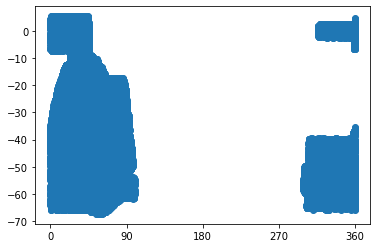

In [134]:
# plt.scatter(plsz2.pl_ra,plsz2.pl_dec)
plt.scatter(wh22.ra,wh22.dec)
plt.xticks([180,90,0,360,270])
# plt.scatter(amf_whl.amf_ra, amf_whl.amf_dec)

(array([10156., 18544., 21483., 22047., 16552., 16590., 14533.,  8288.,
         8428., 14623.]),
 array([-67.37904 , -60.104874, -52.830708, -45.556542, -38.282376,
        -31.00821 , -23.734044, -16.459878,  -9.185712,  -1.911546,
          5.36262 ]),
 <BarContainer object of 10 artists>)

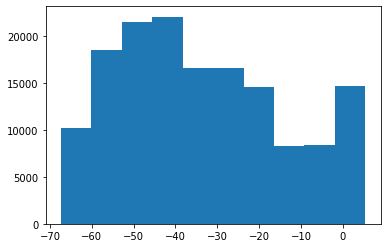

In [121]:
# plt.hist(plsz2.pl_dec)
plt.hist(wh22.dec)